# 1. Set up

### Telling python where things are.

The location of a file or directory is called its path.  

An absolute path tells your computer how to get to the file or directory from the root of the filesystem (roughly speaking the place you land if you keep pressing "parent directory" until it no longer does anything). Depending on your system it should look something like this:  

- Windows: `C:\Users\yaouen\larval_schooling\raw_videos\Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000.avi`  
- MacOS/Linux: `/home/yaouen/larval_schooling/raw_videos/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000.avi`

A relative path tells your computer how to get to the file of directory from wherever you are right now. When running a jupyter notebook, relative means relative to whatever directory the notebook is in.  Depending on your system it should look something like this:  

- Windows: `..\raw_videos\Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000.avi`  
- MacOS/Linux: `../raw_videos/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000.avi`

Here `..` means "go up one directory".


### Suggested directory layout

All having the same directory layout makes it easier to exchange data and python scripts. I suggest you set things up like this:

<pre>
--larval_project
   |
   |--cvtracer
   |
   |--raw_videos
   |   |--Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000.avi
   |   |--Pa_Fri_7dpf_GroupA_n5_2020-06-05-083453-0000.avi
   |
   |--tracking
</pre>


### Pick an output directory for all the trials.

The first line in the code cell below specifies the "tracking directory" where the output of every trial will be saved. By default it is `../tracking`, which means "one directory up from where this notebook is, then into a directory called `tracking`". In other words it conforms to the suggested directory layout. You don't need to change this.

### Pick a video to analyze.


<div class="alert alert-block alert-danger">
<p style="font-size:150%"><b>
Action required
</b></style>
</div>

Change the value of `input_file` below to specify the path to the video you want to analyze (absolute and relative paths both accepted).


In [1]:
tracking_dir = '../tracking'

# input_file = '../raw_videos/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000.avi'
input_file = '../raw_videos/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000.avi'

In [2]:
import platform, os, sys, datetime, re
from os.path import join
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
# sys.path.append(join(root_dir,'cvtracer'))
from cvt.TrAQ.Trial import Trial
from cvt.TrAQ.Tank import Tank
from cvt.TrAQ.Group import Group
from cvt.TrAQ.CVTracer import CVTracer, create_named_window, wait_on_named_window

       
settings_list = [ # trial settings
                  'input_file', 'tracking_dir', 'output_dir', 
                  'new_input_file', 'bkg_file', 'tank_file', 'settings_file', 
                  't_start', 't_end', 'tank_radius', 
                  'bkg_frame_skip', 'bkg_sub_amp',
                  'n_pixel_blur', 'block_size', 'thresh_offset',
                  'min_area', 'max_area', 'RGB', 
                  # tracking settings
                  'ext', 'filename', 'pop', 'age',
                  'group', 'Nfish', 'date',
                  'Nframes', 'fps', 'fourcc',
                  'width', 'height' ]


def set_up_tracking(input_file,tracking_dir=tracking_dir):

    ''' Extract trial info from the filename and the video itself. '''

    filename,ext = os.path.splitext(os.path.basename(input_file))
    pop,_,age,group,Nfish,date = filename.split('_')
    Nfish    = int(re.findall('\d+',Nfish)[0])
    date     = ''.join(date.split('-')[:3])

    cap      = cv2.VideoCapture(input_file)
    cap.read()
    Nframes  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps      = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc   = int(cap.get(cv2.CAP_PROP_FOURCC))
    width    = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()

    ''' Set default tracking parameters. '''

    # By default only track 10 seconds 1 minute in.
    t_start,t_end  = 60,70 # Times between which to track, in seconds.

    # Tank.
    tank_radius    = 10    # Radius of the tank, in centimeters.

    # Background subtraction (for naive background subtraction only).
    bkg_frame_skip = 50    # Using every frame of the video to compute the background takes a while.
                           # Instead we only use one frame in bkg_frame_skip.
    bkg_sub_amp    = 4     # Contrast amplification factor applied after background subtraction.

    # Contour detection.
    n_pixel_blur   =  3    # square-root of n-pixels for threshold blurring
    block_size     = 15    # contour block size
    thresh_offset  = 13    # threshold offset for contour-finding
    min_area       = 20    # minimum area for threhold detection
    max_area       = 500   # maximum area for threhold detection
    RGB            = True  # track in color, false does greyscale
    online_viewer  = True  # Toggle live preview of tracking.

    ''' Define and create necessary folders/files/links. '''
    
    if not os.path.exists(tracking_dir):
        os.mkdir(tracking_dir)

    output_dir = join(tracking_dir,filename)
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    new_input_file = input_file
    if not 'windows' in platform.system().lower():
        new_input_file = join(output_dir,'raw'+ext)
        if not os.path.exists(new_input_file):
            os.symlink(os.path.relpath(input_file,output_dir),new_input_file)

    settings_file = join(output_dir,'tracking_settings.txt')
    tank_file = join(output_dir,'tank.pik')
    bkg_file  = join(output_dir,f'background-{bkg_frame_skip}.npy')
    
    # The list comprehension version fails to find 'new_input_file'.
    # The explicit loop version works. I have no idea why.
#     settings  = { k:locals()[k] for k in settings_list }
    settings = {}
    for k in settings_list:
        settings[k] = locals()[k]
    
    return settings


''' Prepare a one-step settings saving function to run right before tracking. '''

def save_settings():
    with open(settings_file,'w') as fh:
        for k in settings_list:
            print(f'{k} = {globals()[k]}',file=fh)
    return


settings = set_up_tracking(input_file)
globals().update(settings)
# display(settings)

# tank = Tank(new_input_file,tank_radius,output_dir=output_dir)
# if os.path.exists(tank_file):
#     tank.load(tank_file)
# else:
#     tank.locate()

# 2. Track

<div class="alert alert-block alert-danger">
<p style="font-size:150%"><b>
Action required
</b></style>
</div>

Each subsection below (**2.1**, **2.2**, **2.3**) corresponds to a slightly different tracking method. You can try them in any order, any number of times. You can change the values of the parameters in the part of the cells called `parameter tweaking area` and see the effect on the tracking in the live preview window. You can stop the tracking either by closing the live preview window or by pressing the escape key (while the preview window is active).

The first time you analyze a video, a single frame of it will pop up in a new window and you will have to **click on three points on the edge of the tank, then press the space bar twice**. This will create the file `tank.pik` in the output directory. The output directory is located inside the tracking directory we just defined in a subdirectory named after the input video file. If you run this notebook again on the same video file in the future it will load the pre-existing `tank.pik` file. If you want locate the tank again (e.g. because you screwed up the first time), delete the file `tank.pik` in the output directory (using your file browser) then execute this cell again.


## 2.1. No background subtraction

In [3]:
#==========================================================================
# Parameter tweaking area.

t_start,t_end = 60,70 # Times between which to track, in seconds.
# bkg_sub_amp   = 4    # Amplification factor applied after background subtraction.
n_pixel_blur  = 5    # square-root of n-pixels for threshold blurring
block_size    = 15   # contour block size
thresh_offset = 4    # threshold offset for contour-finding
min_area      = 40   # minimum area for threhold detection
max_area      = 100  # maximum area for threhold detection
online_viewer = True # False # 

#==========================================================================
# Actual tracking.

save_settings()
frame_start,frame_end = int(t_start*fps),int(t_end*fps)

trial = Trial(fvideo_raw=new_input_file, output_dir=output_dir, n=Nfish, t=pop, 
              date=date, fps=fps, tank_radius=tank_radius, t_start=t_start, t_end=t_end)

cvt = CVTracer(trial, n_pixel_blur=n_pixel_blur, block_size=block_size, 
               threshold_offset=thresh_offset, min_area=min_area, view_scale=1, RGB=True,
               frame_start=frame_start, frame_end=frame_end, 
               online=online_viewer)

try:
    cvt.set_frame(cvt.frame_start)
    for i_frame in range(cvt.frame_start, cvt.frame_end+1):
        if cvt.get_frame():
            cvt.mask_tank()
            cvt.detect_contours()
            cvt.analyze_contours()
            cvt.connect_frames()
            cvt.update_trial()
            cvt.draw()
            cvt.write_frame()
    #         if cvt.online_viewer:
    #             cvt.draw_contours()
            if not cvt.post_frame(delay=1):
                break
            cvt.print_current_frame()
    cvt.release()
    cvt.trial.save()
except:
    %tb
    cvt.release()


        Unable to load Trial from ../tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/trial.pik 

        Generating new Trial object.

        Tank not found /media/data/work/fau/research/trilab/astyanax_larval_schooling/tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/tank.pik 
    Locating tank edges... 

       Tank detection complete.

        Tank object saved as /media/data/work/fau/research/trilab/astyanax_larval_schooling/tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/tank.pik 
2 individuals in trial
4
Using Gaussian Adaptive Threshold
Using Inverted Binary Threshold with [0, 100].
 Group of 2
       Current tracking time: 00:01:03:23 
       Video capture released.

        Trial object saved as ../tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/trial.pik 


## 2.2. MOG2 background subtraction

Uses openCV's MOG2 algorithm. Added to cvtracer by Adam for the dark astyanax schooling trials.

In [4]:
#==========================================================================
# Parameter tweaking area.

t_start,t_end = 60,70 # Times between which to track, in seconds.
n_pixel_blur  = 3     # square-root of n-pixels for threshold blurring
block_size    = 15    # contour block size
thresh_offset = 4     # threshold offset for contour-finding
min_area      = 15    # minimum area for threhold detection
max_area      = 150   # maximum area for threhold detection
online_viewer = True  # False # 

#==========================================================================
# Actual tracking.

save_settings()
frame_start,frame_end = int(t_start*fps),int(t_end*fps)

trial = Trial(fvideo_raw=new_input_file, output_dir=output_dir, n=Nfish, t=pop, 
              date=date, fps=fps, tank_radius=tank_radius, t_start=t_start, t_end=t_end)

cvt = CVTracer(trial, n_pixel_blur=n_pixel_blur, block_size=block_size, 
               threshold_offset=thresh_offset, min_area=min_area, view_scale=1, RGB=True,
               frame_start=frame_start, frame_end=frame_end, 
               online=online_viewer, 
               MOG2=True)

try:
    cvt.set_frame(cvt.frame_start)
    for i_frame in range(cvt.frame_start, cvt.frame_end+1):
        if cvt.get_frame():
            cvt.mask_tank()
            cvt.mask_background()
            cvt.detect_contours()
            cvt.analyze_contours()
            cvt.connect_frames()
            cvt.update_trial()
            cvt.draw()
            cvt.write_frame()
            if not cvt.post_frame(delay=1):
                break
            cvt.print_current_frame()
    cvt.release()
    cvt.trial.save()
except:
    %tb
    cvt.release()


        Trial loaded from ../tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/trial.pik 
2 individuals in trial
Using MOG2 Background Subtraction
4
Using Gaussian Adaptive Threshold
Using Inverted Binary Threshold with [0, 100].
 Group of 2
       Current tracking time: 00:01:00:86 
       Video capture released.

        Trial object saved as ../tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/trial.pik 


## 2.3. Simple background subtraction

### 2.3.1. Compute the background

Compute the background by averaging frames over the entire video. Save it as `background.npy` in the output directory. Use the pre-existing file if there is one.

0:00:13.742645
Background obtained by averaging every 500th frame over the entire video:


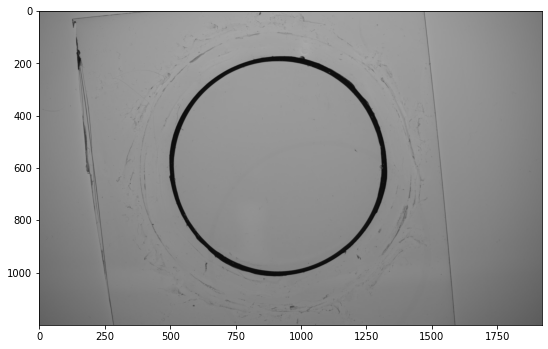

In [7]:
#==========================================================================
# Parameter tweaking area.

# The only parameter here is the frame skipping rate. As an example,
# "bkg_frame_skip = 50" means "only use every 50th frame".
bkg_frame_skip = 500

#==========================================================================

bkg_file  = join(output_dir,f'background-{bkg_frame_skip}.npy')


if os.path.exists(bkg_file):
    bkg  = np.load(bkg_file)
else:
    t0    = datetime.datetime.now()
    cap   = cv2.VideoCapture(new_input_file)
    _,frame = cap.read()
    bkg   = np.zeros(frame.shape,dtype=float)
    count = 0
    # If bkg_frame_skip is small (<10) it may be faster to use
    # cap.grab instead of cap.set.
    for n in range(0,Nframes,bkg_frame_skip):
        cap.set(cv2.CAP_PROP_POS_FRAMES,n)
        ret,frame = cap.read()
        bkg      += frame
        count    += 1
    bkg   = bkg / count
    np.save(bkg_file,bkg)
    print(datetime.datetime.now()-t0)


def subtract_background(frame,bkg=bkg,bkg_sub_amp=bkg_sub_amp):
    return 255-np.minimum(255,bkg_sub_amp*np.absolute(frame-bkg)).astype(np.uint8)    


# Show the background.
print(f'Background obtained by averaging every {bkg_frame_skip}th frame over the entire video:')
plt.figure(figsize=(9,9))
plt.imshow(bkg.astype(np.uint))
plt.show()

### 2.3.2. Preview simple background subtraction

In [8]:
n_skip = 100 # frame skipping rate

window_name = 'background subtraction preview'
create_named_window(window_name)
cap = cv2.VideoCapture(new_input_file)
n   = 0
while True:
#     for i in range(n_skip-1):
#         cap.grab()
    n += n_skip
    cap.set(cv2.CAP_PROP_POS_FRAMES,n)
    ret,frame = cap.read()
    if not ret:
        break
    diff = subtract_background(frame)
#     diff = cv2.GaussianBlur(diff,(5,)*2,0)
    cv2.imshow(window_name,diff)
    if wait_on_named_window(window_name,10)==-2:
        break
cap.release()
cv2.destroyAllWindows()

### 2.3.3. Track with simple background subtraction

In [9]:
#==========================================================================
# Parameter tweaking area.

t_start,t_end = 60,70 # Times between which to track, in seconds.
bkg_sub_amp   = 4     # Amplification factor applied after background subtraction.
n_pixel_blur  = 7     # square-root of n-pixels for threshold blurring
block_size    = 15    # contour block size
thresh_offset = 20    # threshold offset for contour-finding
min_area      = 20    # minimum area for threhold detection
max_area      = 90    # maximum area for threhold detection
online_viewer = True  # False # 

#==========================================================================
# Actual tracking.

save_settings()
frame_start,frame_end = int(t_start*fps),int(t_end*fps)

trial = Trial(fvideo_raw=new_input_file, output_dir=output_dir, n=Nfish, t=pop, 
              date=date, fps=fps, tank_radius=tank_radius, t_start=t_start, t_end=t_end)

cvt = CVTracer(trial, n_pixel_blur=n_pixel_blur, block_size=block_size, 
               threshold_offset=thresh_offset, min_area=min_area, view_scale=1, RGB=True,
               frame_start=frame_start, frame_end=frame_end, 
               online=online_viewer)

try:
    cvt.set_frame(cvt.frame_start)
    for i_frame in range(cvt.frame_start, cvt.frame_end+1):
        if cvt.get_frame():
            cvt.frame = subtract_background(cvt.frame,bkg_sub_amp=bkg_sub_amp)
            cvt.mask_tank()
            cvt.detect_contours()
            cvt.analyze_contours()
            cvt.connect_frames()
            cvt.update_trial()
            cvt.draw()
            cvt.write_frame()
            if not cvt.post_frame(delay=1):
                break
            cvt.print_current_frame()
    cvt.release()
    cvt.trial.save()
except:
    %tb
    cvt.release()


        Trial loaded from ../tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/trial.pik 
2 individuals in trial
20
Using Gaussian Adaptive Threshold
Using Inverted Binary Threshold with [0, 100].
 Group of 2
       Current tracking time: 00:01:00:96 
       Video capture released.

        Trial object saved as ../tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/trial.pik 


In [ ]:
# cv2.destroyAllWindows()